In [87]:
import splitfolders
import shutil
import os
from PIL import Image
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt

global augmented
augmented = False

Build Train/Test/Validation datasets from the given dataset.

In [5]:
def build_directory_dict(root_dir):
    directory_dict = {}

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath != root_dir:
            parent_dir = os.path.basename(dirpath)
            if parent_dir not in directory_dict:
                directory_dict[parent_dir] = []
            for dirname in dirnames:
                directory_dict[parent_dir].append(dirname)

    # check if values for any key is empty then remove that key value pair from dict
    dict_copy = directory_dict.copy()
    print(dict_copy)
    for key, value in dict_copy.items():
        if not value:
            del directory_dict[key]
    return directory_dict

In [6]:
def copy_data_to_dest(source, dest, class_labels, split_ratios):

    for shape, types in class_labels.items():
        src = source + '/' + shape
        temp_dir = source + '/temp/' + shape

        if (os.path.exists(temp_dir)):
            shutil.rmtree(temp_dir) 

        splitfolders.ratio(src, output=temp_dir, ratio=split_ratios, seed=1337)
      
        for type_val in types:
            shutil.move(temp_dir + '/train/' + type_val, dest + '/train/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/test/'  + type_val, dest + '/test/' + shape + '/' + type_val)
            shutil.move(temp_dir + '/val/'   + type_val, dest + '/val/' + shape + '/' + type_val)
        
    shutil.rmtree(r'./Dataset/trafficsigns_dataset/temp')

In [7]:
# use split folders to split the dataset into train, test and validation datasets
def create_train_test_val(split_ratios, src, dest):
    if (os.path.exists(dest)):
        shutil.rmtree(r'./Dataset/train_test_val') 
    splitfolders.ratio(src, output=dest, seed=1337, ratio=split_ratios)
    class_labels = build_directory_dict(src)
    copy_data_to_dest(src, dest, class_labels, split_ratios)
    
    

In [8]:
create_train_test_val(split_ratios=(0.6, 0.2, 0.2), src='Dataset/trafficsigns_dataset', dest='Dataset/train_test_val')  

Copying files: 0 files [00:00, ? files/s]


{'round': ['speed', 'bicycle', 'traveldirection', 'roundabout', 'trafficdirective', 'noentry', 'noparking', 'limitedtraffic'], 'speed': [], 'bicycle': [], 'traveldirection': [], 'roundabout': [], 'trafficdirective': [], 'noentry': [], 'noparking': [], 'limitedtraffic': [], 'hex': ['stop'], 'stop': [], 'square': ['continue', 'crossing', 'laneend', 'parking'], 'continue': [], 'crossing': [], 'laneend': [], 'parking': [], 'diamond': ['rightofway'], 'rightofway': [], 'triangle': ['warning', 'giveway'], 'warning': [], 'giveway': []}


Copying files: 1760 files [00:00, 30228.72 files/s]
Copying files: 43 files [00:00, 20101.99 files/s]
Copying files: 688 files [00:00, 20753.58 files/s]
Copying files: 282 files [00:00, 21869.97 files/s]
Copying files: 926 files [00:00, 24411.70 files/s]


Fetch the images from the folder and build a dataframe

In [9]:
def build_df_from_image_list(image_list):
    df = pd.DataFrame(image_list, columns = ['Path', 'Shape', 'Type'])
    return df

In [10]:
def fetch_images(root_path):
    image_list = []
    for filepath in glob.glob(root_path, recursive=True): #assuming gif
      shape = filepath.split('/')[3]
      types = filepath.split('/')[4]
      image_list.append((filepath, shape, types))
    
    df = build_df_from_image_list(image_list)
    return df

In [11]:
train = fetch_images('Dataset/train_test_val/train/*/*/*.png')
test = fetch_images('Dataset/train_test_val/test/*/*/*.png')
val = fetch_images('Dataset/train_test_val/val/*/*/*.png')

In [12]:
val.head()

,Path,Shape,Type
0,Dataset/train_test_val/val/round/speed/01502_0...,round,speed
1,Dataset/train_test_val/val/round/speed/01774_0...,round,speed
2,Dataset/train_test_val/val/round/speed/01849_0...,round,speed
3,Dataset/train_test_val/val/round/speed/01519_0...,round,speed
4,Dataset/train_test_val/val/round/speed/00935_0...,round,speed


In [13]:
def print_data_info(train, test, val, key='Shape'):
    print("########################## Shape ##########################")
    print(f" Train: {train.shape}, Test: {test.shape}, Val: {val.shape}\n",)
    print("########################## Unique ##########################")
    print("Total Classes: ", len(train[key].unique()))
    print(f" Train: {train[key].unique()}, \nTest: {test[key].unique()}, \nVal: {val[key].unique()}\n")
    print("########################## Count ##########################")
    print(f" Train: {train[key].value_counts()}, Test: {test[key].value_counts()}, Val: {val[key].value_counts()}\n")


In [14]:
print_data_info(train, test, val, key='Shape')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  5
 Train: ['round' 'hex' 'square' 'diamond' 'triangle'], 
Test: ['round' 'hex' 'square' 'diamond' 'triangle'], 
Val: ['round' 'hex' 'square' 'diamond' 'triangle']

########################## Count ##########################
 Train: Shape
round       1054
triangle     555
square       411
diamond      169
hex           25
Name: count, dtype: int64, Test: Shape
round       356
triangle    186
square      141
diamond      57
hex          10
Name: count, dtype: int64, Val: Shape
round       350
triangle    185
square      136
diamond      56
hex           8
Name: count, dtype: int64



In [15]:
print_data_info(train, test, val, key='Type')

########################## Shape ##########################
 Train: (2214, 3), Test: (750, 3), Val: (735, 3)

########################## Unique ##########################
Total Classes:  16
 Train: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway'], 
Test: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway'], 
Val: ['speed' 'bicycle' 'traveldirection' 'roundabout' 'trafficdirective'
 'noentry' 'noparking' 'limitedtraffic' 'stop' 'continue' 'crossing'
 'laneend' 'parking' 'rightofway' 'warning' 'giveway']

########################## Count ##########################
 Train: Type
warning             417
noentry             225
speed               189
bicycle             171
rightofway          169
parking       

Visualise Data

In [16]:
def visualise_data(df):
    # plot distribution of each class
    fig, axs = plt.subplots(1, 2, figsize=(20,6))

    # Plot distribution of each class within shape
    sns.countplot(data=df, x='Shape', ax=axs[0])
    axs[0].set_title('Distribution of Shapes')

    # Plot distribution of each class within type
    sns.countplot(data=df, y='Type', ax=axs[1])
    axs[1].set_title('Distribution of Types')

    plt.tight_layout()
    plt.show()

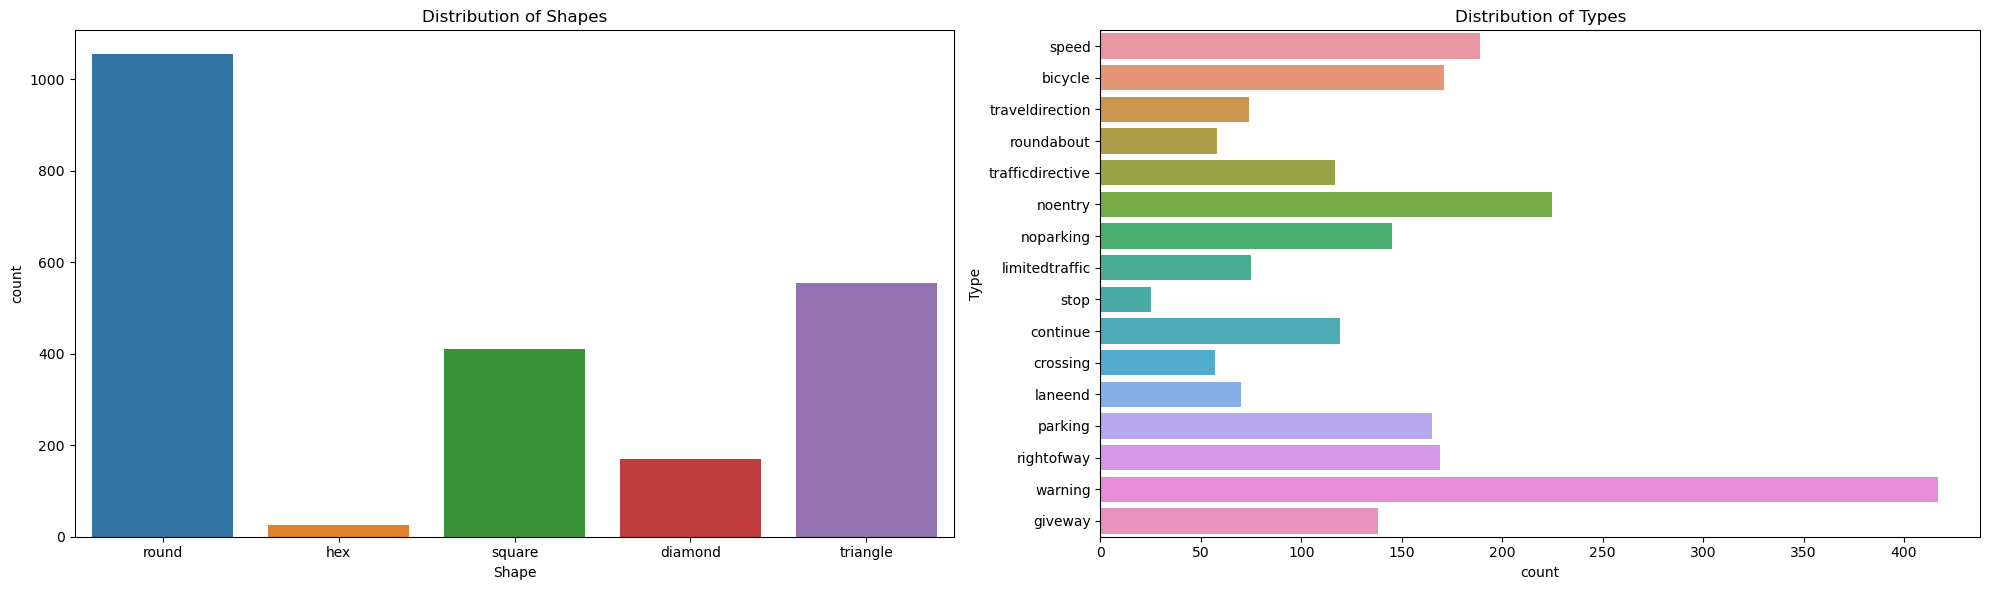

In [17]:
visualise_data(train)

In [18]:
# Iterate through each image path in the DataFrame
def check_image_dimensions(df):
    for index, row in df.iterrows():
        image_path = row['Path']
        flag = False

        # Open the image using PIL
        with Image.open(image_path) as img:
            width, height = img.size
            # Check if dimensions are not 28x28
            if width != 28 or height != 28:
                flag = True
                print(f"Image at path {image_path} has dimensions {width}x{height}")

    if not flag:
        return "All images have dimensions 28x28"

In [19]:
print(f"Train: {check_image_dimensions(train)}\n Test: {check_image_dimensions(test)}\n Val: {check_image_dimensions(val)}")    

Train: All images have dimensions 28x28
 Test: All images have dimensions 28x28
 Val: All images have dimensions 28x28


Encode class labels

In [20]:
def encoder(df):
    label_encoder = LabelEncoder()
    df['Shape'] = label_encoder.fit_transform(df['Shape'])
    df['Type'] = label_encoder.fit_transform(df['Type'])

    return df    

In [22]:
encoder(train)
encoder(test)
encoder(val)
train.head()

,Path,Shape,Type
0,Dataset/train_test_val/train/round/speed/01269...,2,11
1,Dataset/train_test_val/train/round/speed/00224...,2,11
2,Dataset/train_test_val/train/round/speed/01003...,2,11
3,Dataset/train_test_val/train/round/speed/01842...,2,11
4,Dataset/train_test_val/train/round/speed/01238...,2,11


Handle Data Imbalance

In [23]:
def augment_data(df, image_batch_size, dest):
    
    images = []
    for image_path in df['Path']:
        img = plt.imread(image_path)
        images.append(img_to_array(img))
      

    datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
    )

    for img in images:
        img = img.reshape((1,) + img.shape)
        for j, _ in enumerate(datagen.flow(img, save_to_dir=dest, batch_size=1, save_prefix='aug', save_format='png')):
            if j >= image_batch_size:
                break


In [24]:
def make_dir(src, dest):
    if (os.path.exists(dest)):
        if dest == 'Dataset/shape_aug/train':
            shutil.rmtree(r'./Dataset/shape_aug/train')
        elif dest == 'Dataset/type_aug/train':
            shutil.rmtree(r'./Dataset/type_aug/train')
    
    shutil.copytree(src, dest)

In [25]:
def start_shape_augmentation(train, choice, src, dest, batch_dict):
    make_dir(src=src, dest=dest)
    
    for key, [index, value, shape] in batch_dict.items():
        path = dest + '/' + shape + '/' + key
        augment_data(df=train[train.Type == index], image_batch_size=value, dest=path) 
    
    train_aug = fetch_images(dest + '/*/*/*.png')
    train_aug = encoder(train_aug)
    print(train_aug[choice].value_counts())
    visualise_data(train_aug)
    return train_aug

Shape
2    1054
1    1013
3     909
4     825
0     823
Name: count, dtype: int64


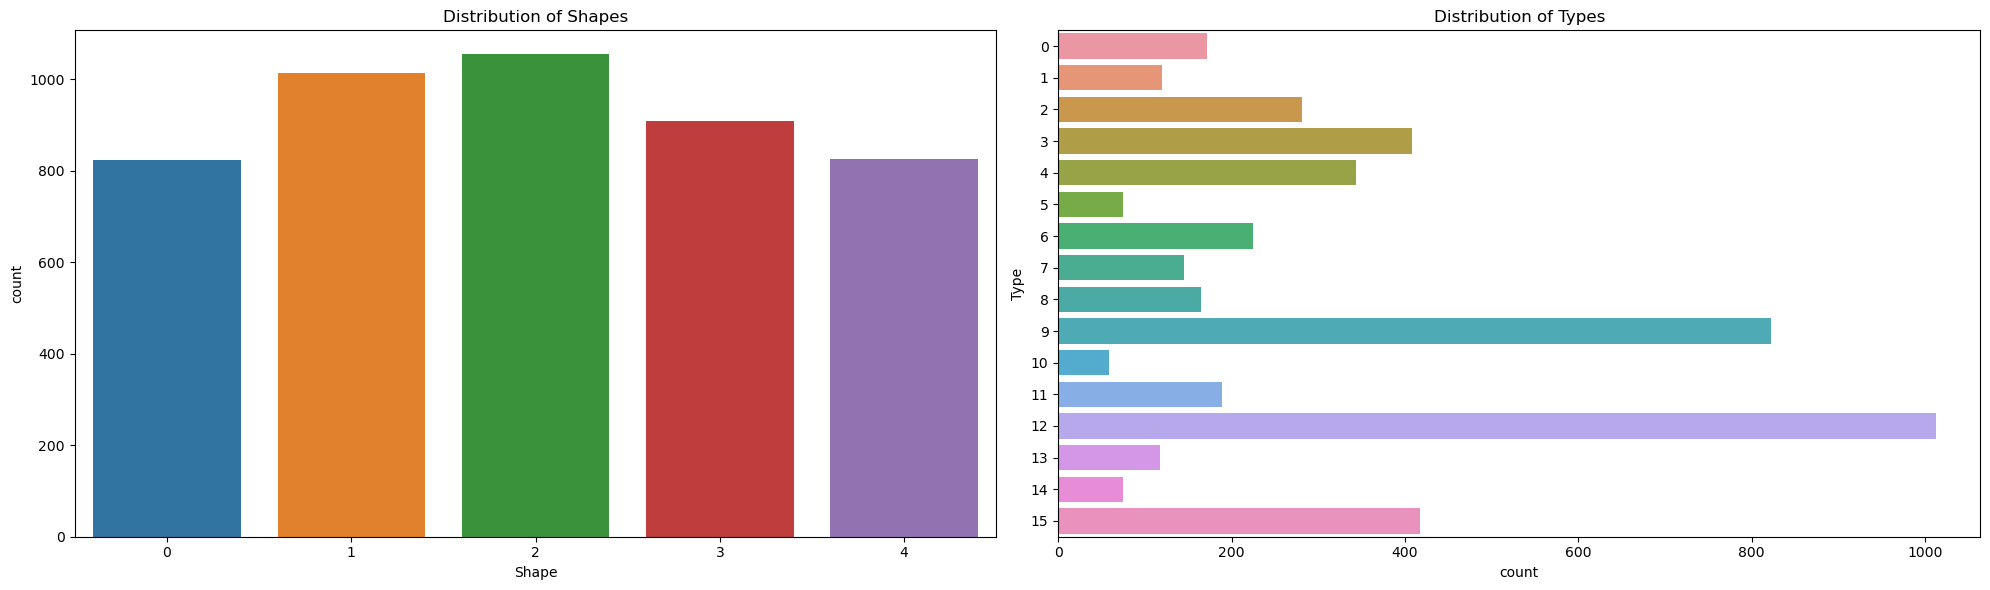

In [26]:
batch_dict_shape = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 41, 'hex'],
        'giveway': [3, 1, 'triangle'],
        'crossing': [2, 3, 'square'],
        'laneend': [4, 3, 'square'],
        'rightofway': [9, 3, 'diamond'],
    }
train_shape_aug = start_shape_augmentation(train, 'Shape', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/shape_aug/train', 
                                           batch_dict=batch_dict_shape)

Type
6     666
13    574
7     572
11    562
3     544
5     513
0     510
14    508
2     503
9     497
8     487
4     479
1     469
10    456
12    440
15    417
Name: count, dtype: int64


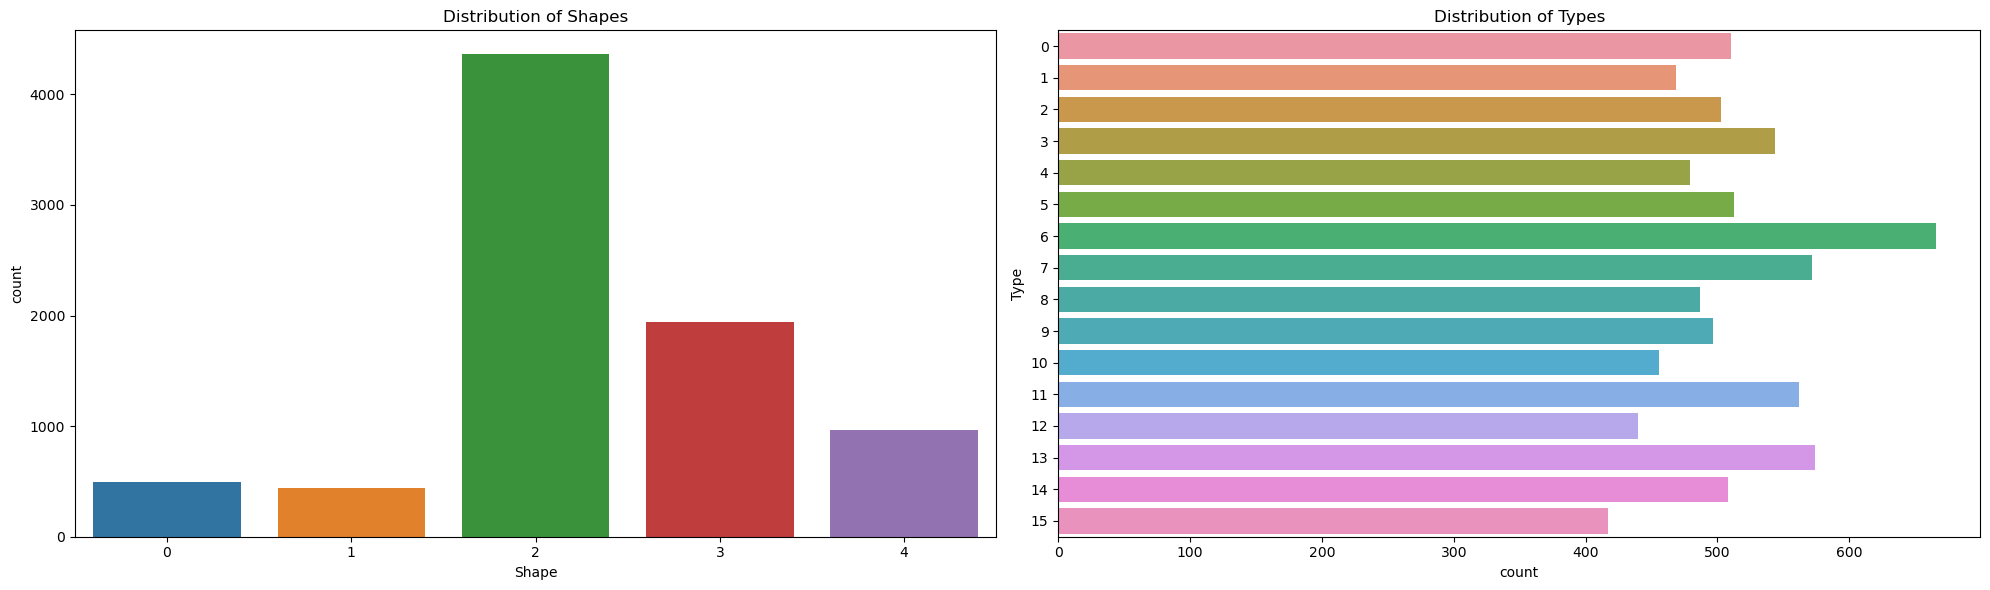

In [27]:
batch_dict_type = {
    # sign_type : [sign_type_label, number of images to generate per image, shape]
        'stop': [12, 16, 'hex'],
        'crossing': [2, 7, 'square'],
        'roundabout': [10, 6, 'round'],
        'laneend': [4, 5, 'square'],
        'traveldirection': [14, 5, 'round'],
        'limitedtraffic': [5, 5, 'round'],
        'trafficdirective': [13, 3, 'round'],
        'continue': [1, 2, 'square'],
        'giveway': [3, 2, 'triangle'],
        'noparking': [7, 2, 'round'],
        'parking': [8, 1, 'square'],
        'rightofway': [9, 1, 'diamond'],
        'bicycle': [0, 1, 'round'],
        'speed': [11, 1, 'round'], 
        'noentry': [6, 1, 'round'],
    }
train_type_augmented = start_shape_augmentation(train, 'Type', 
                                           src='Dataset/train_test_val/train', 
                                           dest='Dataset/type_aug/train', 
                                           batch_dict=batch_dict_type)

In [28]:
def calc_class_weights(df, label):
    unique_labels = train[label].unique()
    weights =  compute_class_weight(class_weight="balanced", classes=df[label].unique(), y=df[label].to_numpy())
    class_weights = dict(zip(unique_labels, weights))
    return class_weights

Generate Images for Training

In [29]:
def create_image_batches(df, batch_size, label, target_size=(28, 28), is_train = True):
        df[label] = df[label].astype('str')
        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

        if is_train:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        color_mode="grayscale",
                        class_mode='categorical')
        else:
                train_generator = train_datagen.flow_from_dataframe(
                        dataframe=df,
                        directory='./',
                        x_col="Path",
                        y_col=label,
                        target_size=target_size,
                        batch_size=batch_size,
                        shuffle=False,
                        color_mode="grayscale",
                        class_mode='categorical'
                        )
        
        return train_generator

In [30]:
# create image batches from train for Shape
shape_train_generator = create_image_batches(df=train, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
shape_val_generator = create_image_batches(df=val, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Shape
shape_aug_train_generator = create_image_batches(df=train_shape_aug, batch_size=32, label='Shape', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 5 classes.
Found 735 validated image filenames belonging to 5 classes.
Found 4624 validated image filenames belonging to 5 classes.


In [31]:
type_train_generator = create_image_batches(df=train, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
type_val_generator = create_image_batches(df=val, batch_size=32, label='Type', target_size=(28, 28), is_train=True)
# create image batches from augmented train for Type
type_aug_train_generator = create_image_batches(df=train_type_augmented, batch_size=32, label='Type', target_size=(28, 28), is_train=True)

Found 2214 validated image filenames belonging to 16 classes.
Found 735 validated image filenames belonging to 16 classes.


Found 8197 validated image filenames belonging to 16 classes.


Model Development

In [32]:
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 16
INPUT_DIM = (28, 28, 1)
# define metrics
METRIC = tf.keras.metrics.AUC(curve='PR', name='PR', from_logits=True)
LOSS_METRIC = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


print(
    f"Classes_Shape: {OUTPUT_CLASSES_SHAPE}\n"
    f"Classes_Type: {OUTPUT_CLASSES_TYPE}\n"
    f"Metric: {METRIC}\n"
    f"Loss Metric: {LOSS_METRIC}\n"
)

Classes_Shape: 5
Classes_Type: 16
Metric: <AUC name=PR>
Loss Metric: <keras.src.losses.losses.CategoricalCrossentropy object at 0x7b44de897550>



2024-05-19 13:35:44.032132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-19 13:35:44.057647: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [33]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [34]:
def plot_performance(history, metric_label):
    val_metric_label = 'val_' + metric_label
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history[metric_label], history.history[val_metric_label], 
                    metric_name = metric_label)

In [35]:
def tune_model(tuner, train_generator, val_generator, class_weights, epoch, tune_type):
    tuner.search(train_generator, validation_data=val_generator, class_weight=class_weights, epochs=epoch, verbose=0)
    best_hp = tuner.get_best_hyperparameters()[0]
    tuned_val = best_hp.get(tune_type)
    print(f"Best {tune_type}: {tuned_val}")
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epoch, verbose=0, class_weight=class_weights)
    plot_performance(history=history, metric_label='PR')
    return model

Fetch class weights

In [36]:
shape_weights = calc_class_weights(df=train, label='Shape')
shape_weights

{'2': 0.42011385199240986,
 '1': 17.712,
 '3': 1.0773722627737226,
 '0': 2.620118343195266,
 '4': 0.7978378378378378}

In [37]:
type_weights = calc_class_weights(df=train, label='Type')
type_weights

{'11': 0.7321428571428571,
 '0': 0.8092105263157895,
 '14': 1.8699324324324325,
 '10': 2.3857758620689653,
 '13': 1.1826923076923077,
 '6': 0.615,
 '7': 0.9543103448275863,
 '5': 1.845,
 '12': 5.535,
 '1': 1.1628151260504203,
 '2': 2.4276315789473686,
 '4': 1.9767857142857144,
 '8': 0.8386363636363636,
 '9': 0.8187869822485208,
 '15': 0.3318345323741007,
 '3': 1.002717391304348}

### Models

Base MLP

In [38]:
################### ADD YOUR BASELINE MLP HERE ################

Base VGG

In [39]:
def build_model_VGG(input_shape, output_classes, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(28, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
   
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(output_classes, activation='softmax'),
    ])

    return model

Tuneable VGG with L2 Regularization

In [94]:
def build_model_VGG_reg_shape(hp):    
    lambda_value = hp.Choice('lambda', [0.006407366308178109, 0.018037870215070927, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [95]:
def build_model_VGG_reg_type(hp):    
    lambda_value = hp.Choice('lambda', [0.1, 0.01, 0.001, 0.0001])
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

Tunable VGG with Dropout Regularization

In [92]:
def build_model_VGG_dropout_shape(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.018037870215070927
    else:
        lambda_value = 0.006407366308178109

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

In [98]:
def build_model_VGG_dropout_type(hp):    
    # choose best lmabda value from tuned lambda
    if not augmented:
        lambda_value = 0.001
    else:
        lambda_value = 0.006407366308178109

    dropout_value = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.2, step=0.1)
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(lambda_value)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE, activation = "softmax"),
    ])

    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[METRIC])

    return model

### Tuners

Lambda Tuner

In [89]:
# Initialize the l2 tuner
def init_lambda_tuner(choice):
    if (os.path.exists('lambda_tuning')):
        shutil.rmtree(r'./lambda_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_reg_shape
    else:
        model_builder = build_model_VGG_reg_type

    lambda_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=3,
        project_name='lambda_tuning')
    return lambda_tuner

Dropout Tuner

In [90]:
# Initialize the droput tuner
def init_dropout_tuner(choice):
    if (os.path.exists('dropout_tuning')):
        shutil.rmtree(r'./dropout_tuning')
    
    if choice == 'Shape':
        model_builder = build_model_VGG_dropout_shape
    else:
        model_builder = build_model_VGG_dropout_type
    
    dropout_tuner = kt.RandomSearch(
        model_builder,
        objective='val_loss',
        max_trials=4,
        project_name='dropout_tuning')
    return dropout_tuner

Baseline Model

In [40]:
# Add your baseline model here

Convolutional Neural Network (CNN)

In [46]:
def compile_model(model, optimiser='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy']):
    model.compile(optimizer=optimiser, loss=loss, metrics=metrics)
    return model

In [47]:
def train_model(model, train_generator, val_generator, epochs=50, class_weights=None):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, class_weight=class_weights, verbose=0)
    return history

In [72]:
def pipeline(train, val, metric_label, optimiser, activation, epoch, class_weights, output_classes):
    model = build_model_VGG(input_shape=INPUT_DIM, output_classes=output_classes, activation=activation)
    model = compile_model(model, optimiser=optimiser, loss=LOSS_METRIC, metrics=[METRIC])
    history = train_model(model, train, val, epochs=epoch, class_weights=class_weights)
    plot_performance(history=history, metric_label=metric_label)
    return model


VGG with Adam Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


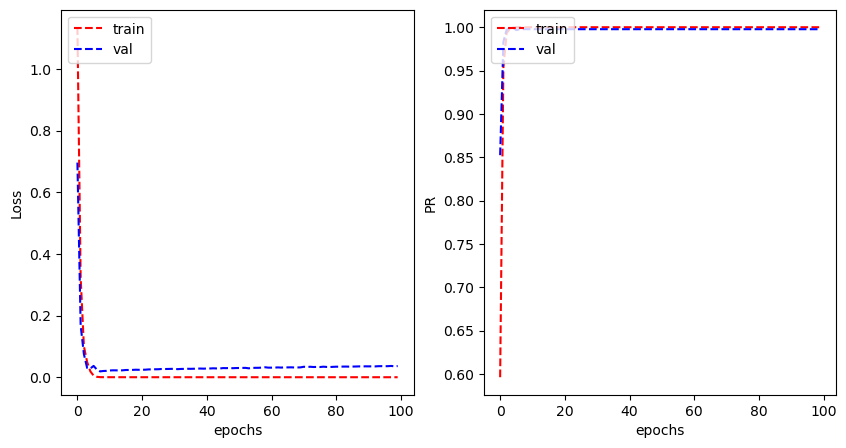

In [49]:
model_VGG_base_adam_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='adam',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE,
                          class_weights=None)

VGG with SGD Optimiser

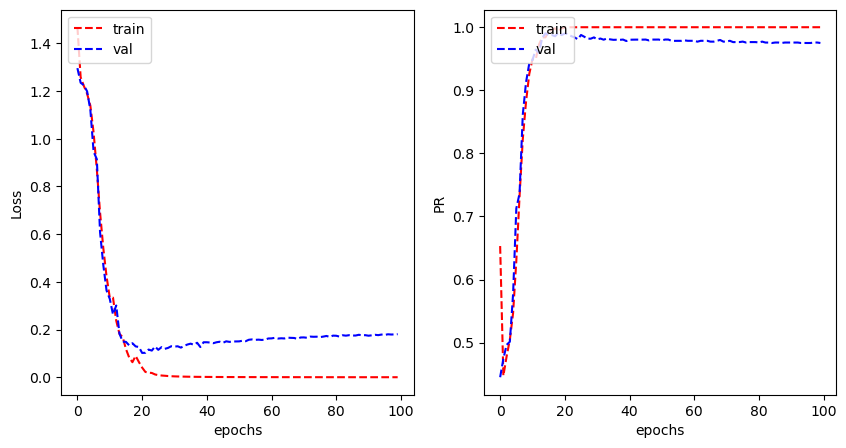

In [50]:
model_VGG_base_SGD_shape = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE, 
                          class_weights=None)

In [51]:
model_VGG_base_SGD_shape.save('models/shape/model_VGG_base_SGD_shape.keras')

Class Re-Weighting

VGG with Class Re-Weighting

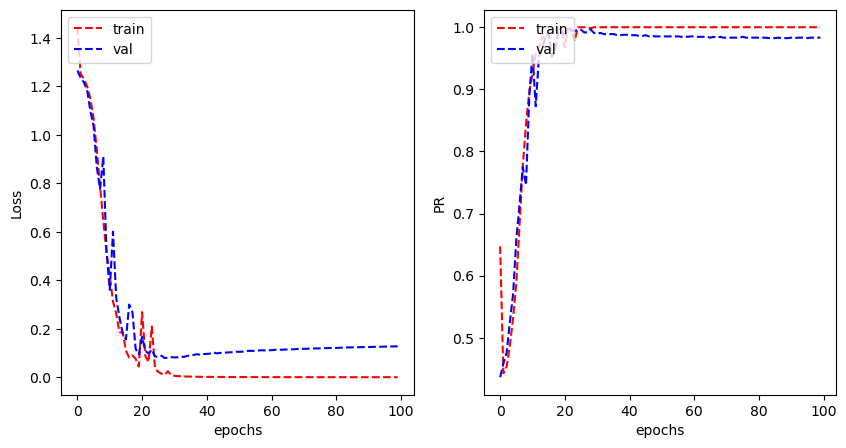

In [52]:
model_VGG_base_SGD_shape_reweighted = pipeline(shape_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_SHAPE,
                          class_weights=shape_weights)

In [53]:
model_VGG_base_SGD_shape_reweighted.save('models/shape/model_VGG_base_SGD_shape_reweighted.keras')

L2 Regularisation

Best lambda: 0.018037870215070927


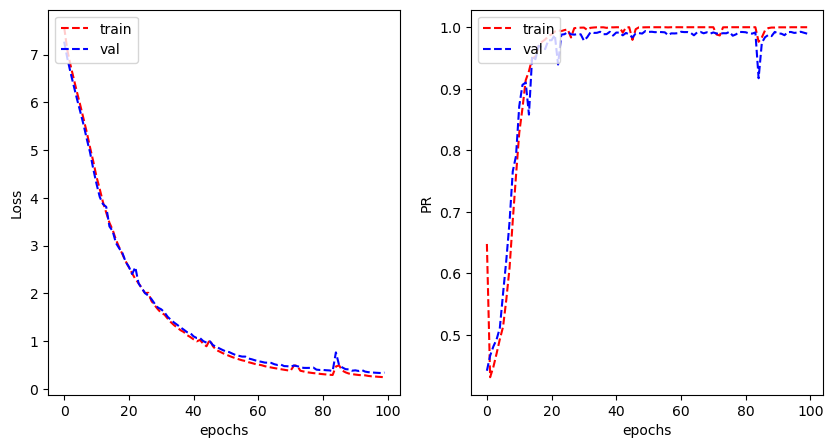

In [54]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape = tune_model(lambda_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [55]:
best_model_l2_shape.save('models/shape/best_model_l2_shape.keras')

Dropout Regularisation

Best dropout_rate: 0.2


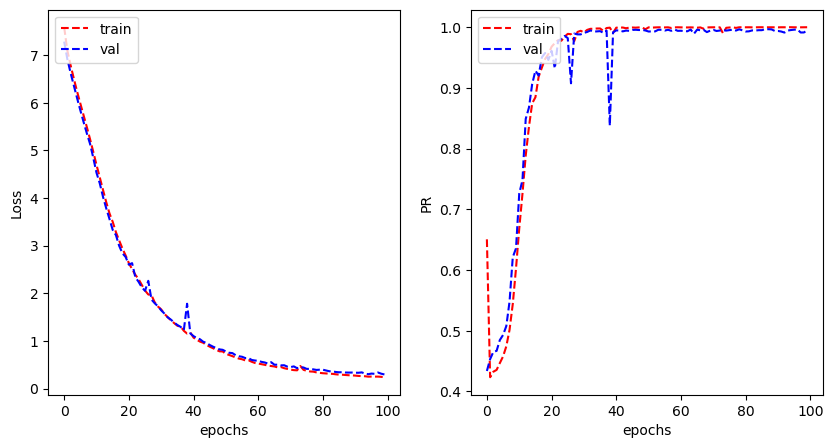

In [56]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_droput_shape = tune_model(dropout_tuner, shape_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [57]:
best_model_droput_shape.save('models/shape/best_model_droput_shape.keras')

Augmented Data

In [99]:
augmented = True

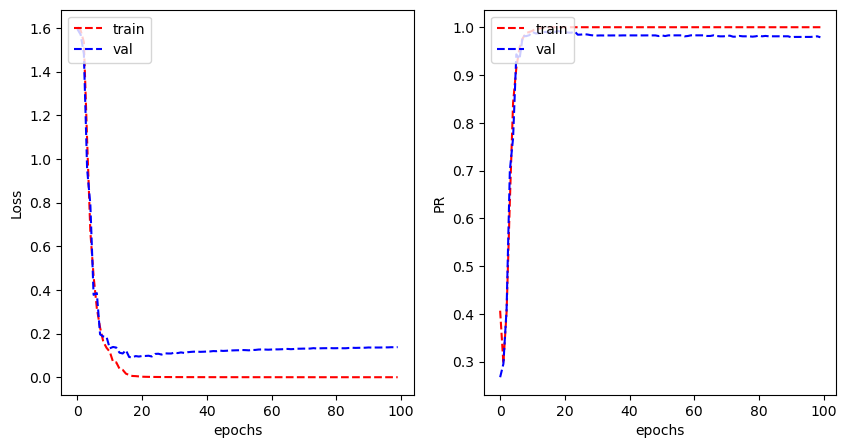

In [58]:
model_VGG_base_SGD_shape_aug = pipeline(shape_aug_train_generator, 
                          shape_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          class_weights=None)

In [59]:
model_VGG_base_SGD_shape_aug.save('models/shape/model_VGG_base_SGD_shape_aug.keras')

Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.006407366308178109


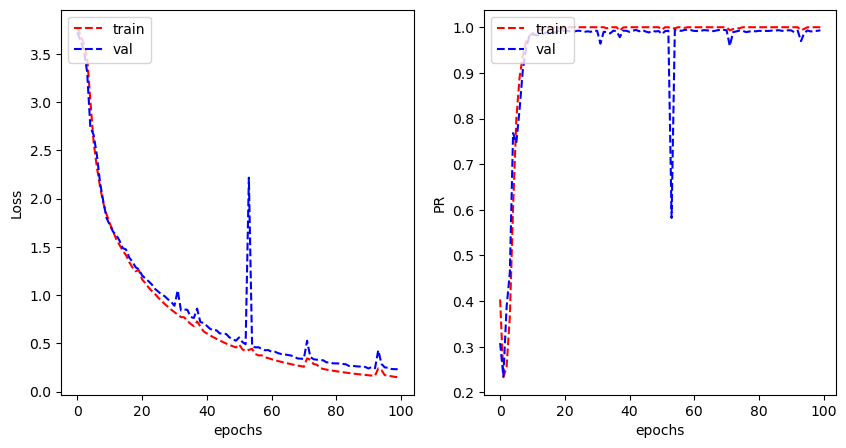

In [66]:
lambda_tuner = init_lambda_tuner(choice='Shape')
best_model_l2_shape_aug = tune_model(lambda_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'lambda')

In [67]:
best_model_l2_shape_aug.save('models/shape/best_model_l2_shape_aug.keras')

Dropout

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best dropout_rate: 0.30000000000000004


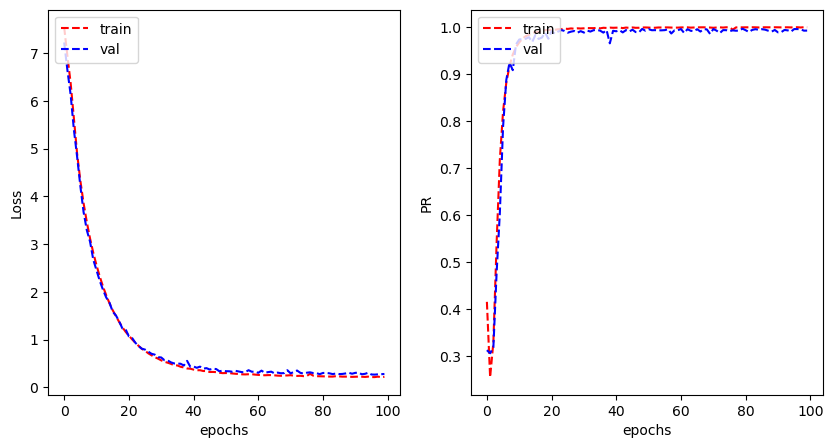

In [68]:
dropout_tuner = init_dropout_tuner(choice='Shape')
best_model_dropout_shape_aug = tune_model(dropout_tuner, shape_aug_train_generator, shape_val_generator, shape_weights, 100, 'dropout_rate')

In [69]:
best_model_dropout_shape_aug.save('models/shape/best_model_droput_shape_aug.keras')

Type

In [100]:
augmented = False

Base SGD Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as

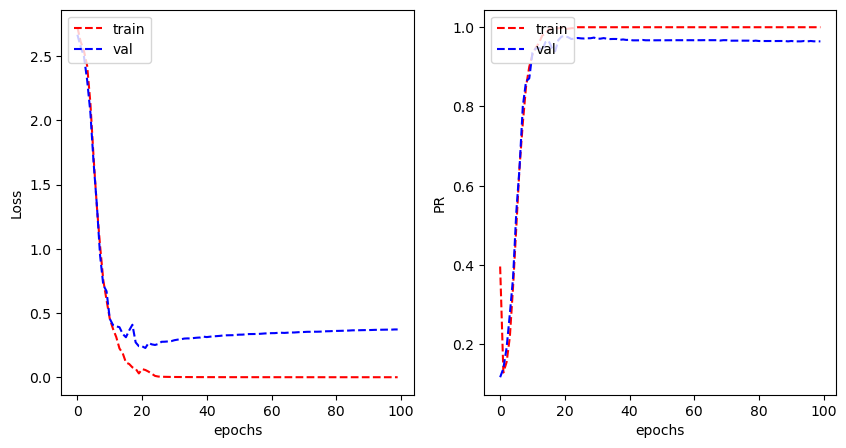

In [73]:
model_VGG_base_SGD_type = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [74]:
model_VGG_base_SGD_type.save('models/type/model_VGG_base_SGD_type.keras')

Reweighted SGD Optimiser

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


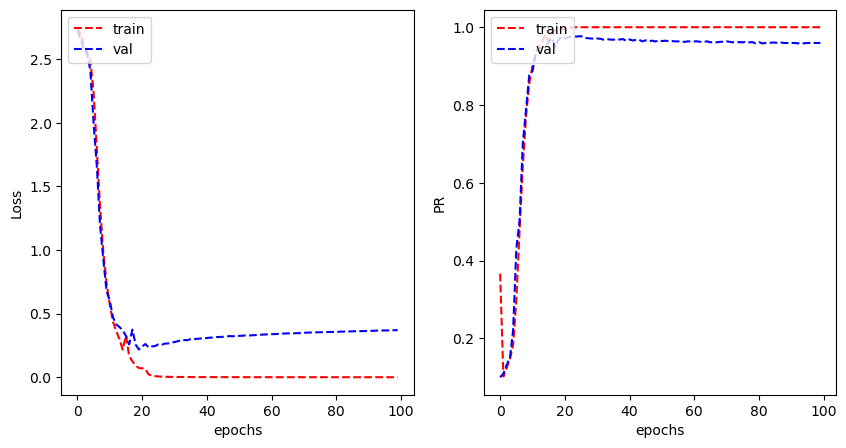

In [75]:
model_VGG_base_SGD_type_reweighted = pipeline(type_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=type_weights)

In [76]:
model_VGG_base_SGD_type_reweighted.save('models/type/model_VGG_base_SGD_type_reweighted.keras')

L2 Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.001


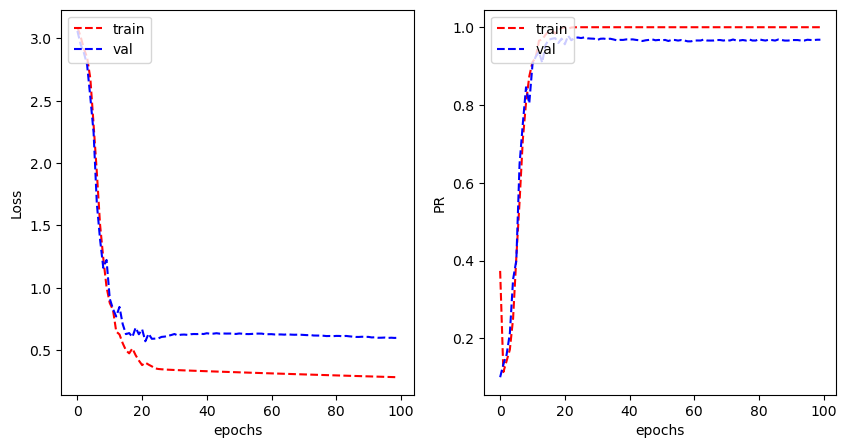

In [93]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type = tune_model(lambda_tuner, type_train_generator, type_val_generator, type_weights, 100, 'lambda')

In [104]:
best_model_l2_type.save('models/type/best_model_l2_type.keras')

Dropout Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best dropout_rate: 0.4


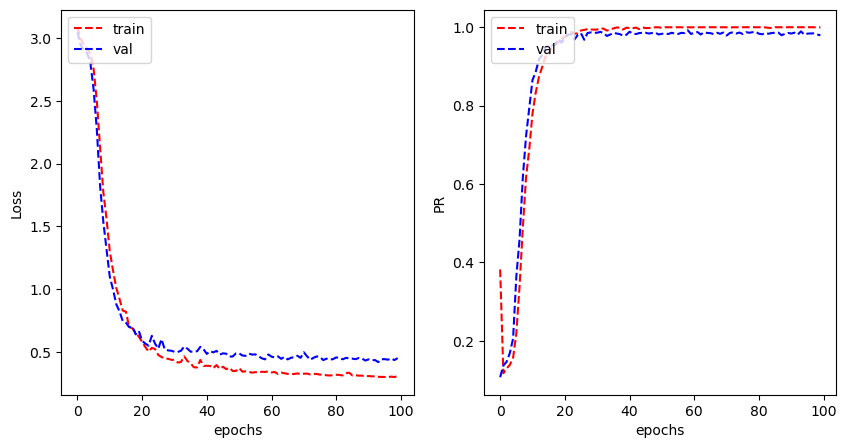

In [101]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type = tune_model(dropout_tuner, type_train_generator, type_val_generator, type_weights, 100, 'dropout_rate')

In [103]:
best_model_droput_type.save('models/type/best_model_droput_type.keras')

Augmented Data

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


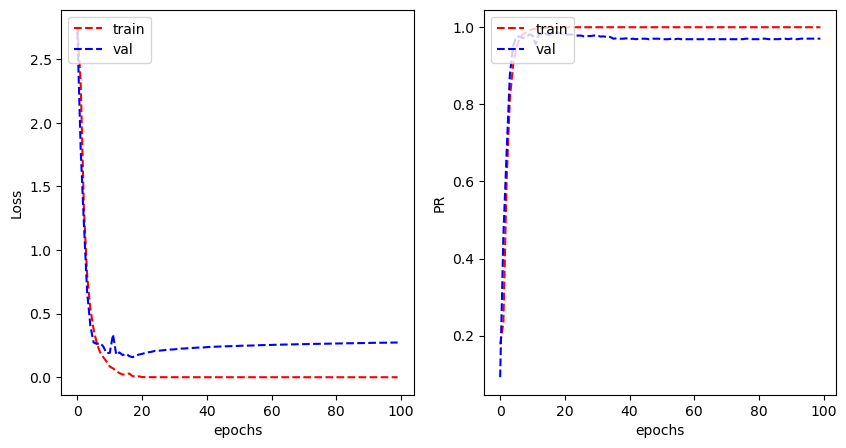

In [102]:
model_VGG_base_SGD_type_aug = pipeline(type_aug_train_generator, 
                          type_val_generator, 
                          metric_label='PR',
                          optimiser='sgd',
                          activation='relu',
                          epoch=100,
                          output_classes=OUTPUT_CLASSES_TYPE,
                          class_weights=None)

In [105]:
model_VGG_base_SGD_type_aug.save('models/type/model_VGG_base_SGD_type_aug.keras')

L2 Regularisation

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best lambda: 0.0001


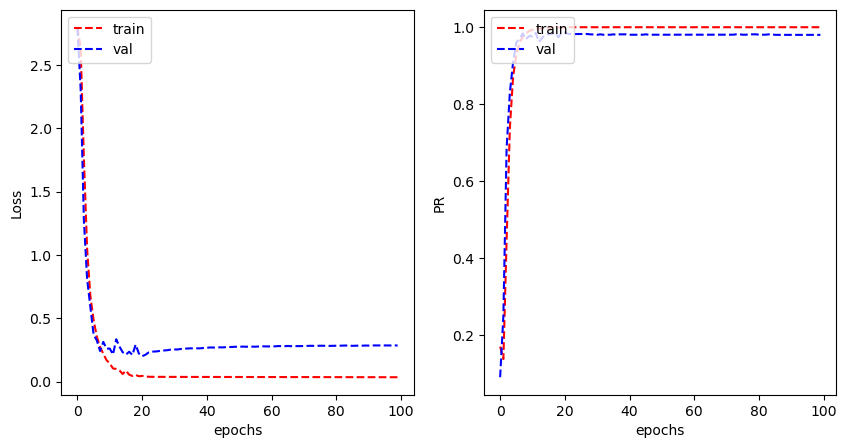

In [106]:
lambda_tuner = init_lambda_tuner(choice='Type')
best_model_l2_type_aug = tune_model(lambda_tuner, type_aug_train_generator, type_val_generator, None, 100, 'lambda')

In [107]:
best_model_l2_type_aug.save('models/type/best_model_l2_type_aug.keras')

Dropout Regularisation

In [ ]:
dropout_tuner = init_dropout_tuner(choice='Type')
best_model_droput_type_aug = tune_model(dropout_tuner, type_aug_train_generator, type_val_generator, None, 100, 'dropout_rate')

In [ ]:
best_model_droput_type_aug.save('models/type/best_model_droput_type_aug.keras')

### Testing